## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

Zurich, Switzerland is home to a large number of financial institutions and banking companies, and the low tax rates attract overseas companies to set up their headquarters there.
It is also a great tourist destination and is home to a few UNESCO world heritage sites. 
In this project we will determine the optimal location to open a restaurant in the Zurich district, and will be targeted at stakeholders interested in opening a restaurant in Zurich. 
Since we are not aware of what type of restaurant is popular in Zurich, we will also determine the most popular type(s) of restaurants in Zurich. We will utilize data science and machine learning techniques in order to do this.


## Data <a name="data"></a>

In this project we will utilize three datasets in order to solve our problem. The first dataset is a list of municipalities and information regarding them such as which district it is in. This data set was scraped from Wikipedia. The next data set is one contain the latitude and longitude for each municipality. This dataset was obtaining from taking the coordinates from each of the Wikipedia pages of the municipalities and pasting them into a CSV file using excel. The file containing the list of venues was obtained using the Foursquare API. We selected all venues not just restaurants in order to see where restaurants were more popular. 

In [72]:
#import all libraries needed
from bs4 import BeautifulSoup #library for web scraping
import requests

import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment to install
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
# import k-means from clustering stage
from sklearn.cluster import KMeans
#for determining optimal k
from sklearn import metrics
from scipy.spatial.distance import cdist



#!conda install -c conda-forge folium=0.5.0 --yes # uncomment to install 
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


### Obtaining the data 

first lets scrape a table from wikipedia 

In [3]:
link = requests.get('https://en.wikipedia.org/wiki/Z%C3%BCrich_District').text

table = pd.read_html(link, header=0, attrs={"class":"wikitable sortable"})[0]
table.head()

,CoA,Name,Merger,District
0,NaN,Affoltern,1934,11
1,NaN,Albisrieden,1934,9
2,NaN,Altstadt,1893,1
3,NaN,Altstetten,1934,9
4,NaN,Aussersihl,1893,4 and 5


Let's clean the data,
first we will drop the columns we don't need, and rename the 'Name' column


In [4]:
zurich_df = table.drop(['CoA', 'Merger'], axis=1)
zurich_df.rename(columns={'Name':'Municipalities'}, inplace=True)
zurich_df.head()

,Municipalities,District
0,Affoltern,11
1,Albisrieden,9
2,Altstadt,1
3,Altstetten,9
4,Aussersihl,4 and 5


Next we import the Longitude and Latitude data  for each Municipality

In [17]:
z_l=pd.read_csv(r'C:\Users\a\Desktop/projects/Coursera_Capstone/zurich.csv' )
z_l.head()

,Municipalities,Latitude,Longitude
0,Affoltern,47.418611,8.506111
1,Albisrieden,47.374350,8.483119
2,Altstadt,47.370000,8.542000
3,Altstetten,47.384969,8.477175
4,Aussersihl,47.375000,8.527000


Merge the two dataframes

In [30]:
zurich = zurich_df.merge(z_l, left_on='Municipalities', right_on='Municipalities')
zurich.head()

,Municipalities,District,Latitude,Longitude
0,Affoltern,11,47.418611,8.506111
1,Albisrieden,9,47.374350,8.483119
2,Altstetten,9,47.384969,8.477175
3,Aussersihl,4 and 5,47.375000,8.527000
4,Enge,2,47.363611,8.531111


In [45]:
zurich.rename(columns={'Latitude \t':'Latitude'}, inplace=True)
print(zurich.columns)

Index(['Municipalities', 'District', 'Latitude', 'Longitude'], dtype='object')


In [20]:
address = 'Zurich District, Switzerland.'
geolocater = Nominatim(user_agent = 'ny_explorer')
location = geolocater.geocode(address)
latitude = location.latitude
longitude = location.longitude 
print('The geograpical coordinates of Zurich are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of Zurich are 47.3723941, 8.5423328.


Next we are going to use the Foursquare API to obtain venue data 

In [22]:
#removed for security reasons
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: M3FLJYCCTBLUK5BIFFJY1WKSOF0UFXB2QBIHT51WIDAJGRPP
CLIENT_SECRET:24ASR43ML2QXF5I01MRGRD0D4MZP04WHLBWZ13IEMTLANQVV


Let's create a function to get the venues  

In [46]:
LIMIT=100#top 100
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Municipalities', 
                  'Latitude', 
                  'Longitude', 
                  'Venue', 
                  'Venue Latitude', 'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)


In [47]:
zurich_venues = getNearbyVenues(zurich['Municipalities'],
                                   latitudes=zurich['Latitude'],
                                   longitudes=zurich['Longitude']
                                  )

Affoltern
Albisrieden
Altstetten
Aussersihl
Enge
Fluntern
Hirslanden
Höngg
Oberstrass
Oerlikon
Riesbach
Schwamendingen
Seebach
Unterstrass
Wiedikon
Wipkingen
Witikon
Wollishofen


In [51]:
print(zurich_venues.shape)
zurich_venues.head()

(423, 7)


,Municipalities,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Affoltern,47.418611,8.506111,Migros,47.420404,8.508402,Supermarket
1,Affoltern,47.418611,8.506111,Bahnhof Zürich Affoltern,47.420950,8.507619,Train Station
2,Affoltern,47.418611,8.506111,Coop,47.419237,8.505753,Supermarket
3,Affoltern,47.418611,8.506111,Einkaufszentrum Affoltern,47.419593,8.507790,Department Store
4,Affoltern,47.418611,8.506111,Pizzeria Piazza,47.419276,8.505978,Italian Restaurant


Check the Venues Returned for each Municipality 

In [52]:
zurich_venues.groupby('Municipalities').count()

,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Municipalities,,,,,,
Affoltern,14,14,14,14,14,14
Albisrieden,7,7,7,7,7,7
Altstetten,2,2,2,2,2,2
Aussersihl,100,100,100,100,100,100
Enge,48,48,48,48,48,48
Fluntern,14,14,14,14,14,14
Hirslanden,16,16,16,16,16,16
Höngg,21,21,21,21,21,21
Oberstrass,15,15,15,15,15,15


## Methodology <a name="methodology"></a>

We begin our analysis by utilizing one hot encoding on the data, in order to make it easier to work with catgorical variables, use 1 to represent a venue catagory being present, and 0 to represent it not being present.

In [55]:
# one hot encoding
z_onehot = pd.get_dummies(zurich_venues[['Venue Category']], prefix="", prefix_sep="")

# add municipalities column back to dataframe
z_onehot['Municipalities'] = zurich_venues['Municipalities'] 

# move municipalities column to the first column
fixed_columns = [z_onehot.columns[-1]] + list(z_onehot.columns[:-1])
z_onehot = z_onehot[fixed_columns]

print(z_onehot.shape)
z_onehot.head()

(423, 117)


,Municipalities,Antique Shop,Argentinian Restaurant,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bakery,Bar,Bath House,Beach,Beer Garden,Bike Trail,Bistro,Bookstore,Botanical Garden,Breakfast Spot,Burger Joint,Burrito Place,Bus Station,Bus Stop,Cable Car,Cafeteria,Café,Cheese Shop,Chinese Restaurant,Cocktail Bar,Coffee Shop,College Academic Building,Community Center,Cupcake Shop,Department Store,Diner,Discount Store,Eastern European Restaurant,Ethiopian Restaurant,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Flower Shop,Food & Drink Shop,Food Court,French Restaurant,Gas Station,Gastropub,Gay Bar,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,History Museum,Hookah Bar,Hostel,Hotel,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Italian Restaurant,Japanese Restaurant,Kids Store,Korean Restaurant,Laser Tag,Lebanese Restaurant,Light Rail Station,Lounge,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Movie Theater,Multiplex,Museum,Music Venue,Nightclub,Other Great Outdoors,Park,Performing Arts Venue,Pharmacy,Pizza Place,Playground,Plaza,Pool,Pool Hall,Pub,Restaurant,River,Rock Club,Salad Place,Sandwich Place,Sauna / Steam Room,Scenic Lookout,Shopping Mall,Snack Place,Soccer Field,Soup Place,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Bar,Sri Lankan Restaurant,Steakhouse,Supermarket,Sushi Restaurant,Swiss Restaurant,Taverna,Thai Restaurant,Train Station,Tram Station,Trattoria/Osteria,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Water Park,Wine Bar,Yoga Studio
0,Affoltern,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,Affoltern,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,Affoltern,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,Affoltern,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Affoltern,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Next we will group rows by muncipality and mean of frequency of occurance of each catageory 

In [57]:
z_grouped = z_onehot.groupby('Municipalities').mean().reset_index()
z_grouped

,Municipalities,Antique Shop,Argentinian Restaurant,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bakery,Bar,Bath House,Beach,Beer Garden,Bike Trail,Bistro,Bookstore,Botanical Garden,Breakfast Spot,Burger Joint,Burrito Place,Bus Station,Bus Stop,Cable Car,Cafeteria,Café,Cheese Shop,Chinese Restaurant,Cocktail Bar,Coffee Shop,College Academic Building,Community Center,Cupcake Shop,Department Store,Diner,Discount Store,Eastern European Restaurant,Ethiopian Restaurant,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Flower Shop,Food & Drink Shop,Food Court,French Restaurant,Gas Station,Gastropub,Gay Bar,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,History Museum,Hookah Bar,Hostel,Hotel,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Italian Restaurant,Japanese Restaurant,Kids Store,Korean Restaurant,Laser Tag,Lebanese Restaurant,Light Rail Station,Lounge,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Movie Theater,Multiplex,Museum,Music Venue,Nightclub,Other Great Outdoors,Park,Performing Arts Venue,Pharmacy,Pizza Place,Playground,Plaza,Pool,Pool Hall,Pub,Restaurant,River,Rock Club,Salad Place,Sandwich Place,Sauna / Steam Room,Scenic Lookout,Shopping Mall,Snack Place,Soccer Field,Soup Place,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Bar,Sri Lankan Restaurant,Steakhouse,Supermarket,Sushi Restaurant,Swiss Restaurant,Taverna,Thai Restaurant,Train Station,Tram Station,Trattoria/Osteria,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Water Park,Wine Bar,Yoga Studio
0,Affoltern,0.000000,0.000000,0.000000,0.000000,0.000000,0.071429,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.071429,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.214286,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.071429,0.071429,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.071429,0.00,0.000000,0.00,0.071429,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.071429,0.0000,0.00,0.000000,0.000000,0.071429,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.142857,0.00,0.000000,0.000000,0.000000,0.071429,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.000000
1,Albisrieden,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.285714,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.142857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.142857,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.142857,0.00,0.142857,0.000000,0.000000,0.000000,0.000000,0.142857,0.00,0.000000,0.00,0.000000,0.000000
2,Altstetten,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000

In [58]:
z_grouped.shape

(18, 117)

Print with each Municipality along with its top 5 venues 

In [61]:
 num_top_venues = 5

for municipality in z_grouped['Municipalities']:
    print("----"+municipality+"----")
    temp = z_grouped[z_grouped['Municipalities'] == municipality].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Affoltern----
                venue  freq
0         Bus Station  0.21
1         Supermarket  0.14
2  Italian Restaurant  0.07
3               Diner  0.07
4    Department Store  0.07


----Albisrieden----
               venue  freq
0        Bus Station  0.29
1      Grocery Store  0.14
2        Supermarket  0.14
3  Trattoria/Osteria  0.14
4     Scenic Lookout  0.14


----Altstetten----
          venue  freq
0          Pool   0.5
1  Soccer Field   0.5
2  Antique Shop   0.0
3        Museum   0.0
4     Pool Hall   0.0


----Aussersihl----
                venue  freq
0                 Bar  0.14
1  Italian Restaurant  0.09
2          Restaurant  0.07
3    Swiss Restaurant  0.06
4                Café  0.04


----Enge----
                venue  freq
0  Italian Restaurant  0.08
1               Hotel  0.08
2        Tram Station  0.06
3                 Bar  0.06
4               Plaza  0.04


----Fluntern----
           venue  freq
0   Tram Station  0.21
1  Grocery Store  0.14
2          Plaza 

Now we arrange this into a data frame

In [62]:
#A function to sort the venues in descending order.

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [71]:
#Now let's create the new dataframe and display the top 10 venues for each Municipality.

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Municipalities']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
z_venues_sorted = pd.DataFrame(columns=columns)
z_venues_sorted['Municipalities'] = z_grouped['Municipalities']

for ind in np.arange(z_grouped.shape[0]):
    z_venues_sorted.iloc[ind, 1:] = return_most_common_venues(z_grouped.iloc[ind, :], num_top_venues)

z_venues_sorted.head()

,Municipalities,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Affoltern,Bus Station,Supermarket,Department Store,Train Station,Bike Trail,Music Venue,Miscellaneous Shop,Athletics & Sports,Hotel,Italian Restaurant
1,Albisrieden,Bus Station,Grocery Store,Swiss Restaurant,Trattoria/Osteria,Scenic Lookout,Supermarket,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Yoga Studio
2,Altstetten,Pool,Soccer Field,Yoga Studio,College Academic Building,Cupcake Shop,Department Store,Diner,Discount Store,Eastern European Restaurant,Ethiopian Restaurant
3,Aussersihl,Bar,Italian Restaurant,Restaurant,Swiss Restaurant,Café,Thai Restaurant,Chinese Restaurant,Coffee Shop,Nightclub,Pub
4,Enge,Hotel,Italian Restaurant,Tram Station,Bar,Restaurant,French Restaurant,Plaza,Park,Supermarket,Yoga Studio


### Clustering

For this project we will be using K-Means Clustering, first of all we need to determine the best k, in order to this we will use the elbow method to determine the optimal number of clusters

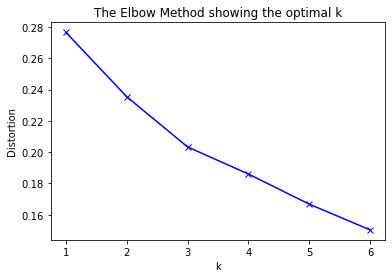

In [106]:
X = z_grouped.drop('Municipalities', 1)
distortions = []
K = range(1,7)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()


From the above it seems that the optimal k is 3

In [112]:
k_o = 3

kmeans= KMeans(n_clusters=k_o, random_state=0).fit(X)

kl=kmeans.labels_
kl

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0])

Now let's create a new data frame that includes the cluster and the top 10 venues

In [129]:
z_venues_sorted.insert(0, 'Cluster Labels', kl)

z_merged = zurich
z_merged = z_merged.join(z_venues_sorted.set_index('Municipalities'), on ='Municipalities')

z_merged.head()

,Municipalities,District,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Affoltern,11,47.418611,8.506111,0,Bus Station,Supermarket,Department Store,Train Station,Bike Trail,Music Venue,Miscellaneous Shop,Athletics & Sports,Hotel,Italian Restaurant
1,Albisrieden,9,47.374350,8.483119,0,Bus Station,Grocery Store,Swiss Restaurant,Trattoria/Osteria,Scenic Lookout,Supermarket,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Yoga Studio
2,Altstetten,9,47.384969,8.477175,1,Pool,Soccer Field,Yoga Studio,College Academic Building,Cupcake Shop,Department Store,Diner,Discount Store,Eastern European Restaurant,Ethiopian Restaurant
3,Aussersihl,4 and 5,47.375000,8.527000,0,Bar,Italian Restaurant,Restaurant,Swiss Restaurant,Café,Thai Restaurant,Chinese Restaurant,Coffee Shop,Nightclub,Pub
4,Enge,2,47.363611,8.531111,0,Hotel,Italian Restaurant,Tram Station,Bar,Restaurant,French Restaurant,Plaza,Park,Supermarket,Yoga Studio


### Create a map to visualize clusters 

In [119]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=8)

# set color scheme for the clusters
x = np.arange(k_o)
ys = [i + x + (i*x)**2 for i in range(k_o)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(z_merged['Latitude'], z_merged['Longitude'], z_merged['Municipalities'], z_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Cluster 1

In [131]:
z_merged.loc[z_merged['Cluster Labels'] == 0, z_merged.columns[[0] + list(range(5, z_merged.shape[1]))]]

,Municipalities,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Affoltern,Bus Station,Supermarket,Department Store,Train Station,Bike Trail,Music Venue,Miscellaneous Shop,Athletics & Sports,Hotel,Italian Restaurant
1,Albisrieden,Bus Station,Grocery Store,Swiss Restaurant,Trattoria/Osteria,Scenic Lookout,Supermarket,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Yoga Studio
3,Aussersihl,Bar,Italian Restaurant,Restaurant,Swiss Restaurant,Café,Thai Restaurant,Chinese Restaurant,Coffee Shop,Nightclub,Pub
4,Enge,Hotel,Italian Restaurant,Tram Station,Bar,Restaurant,French Restaurant,Plaza,Park,Supermarket,Yoga Studio
5,Fluntern,Tram Station,Plaza,Grocery Store,Bakery,Supermarket,Pizza Place,Bus Station,Gym Pool,Gastropub,Cafeteria
6,Hirslanden,Hotel,Park,Bus Station,Italian Restaurant,Swiss Restaurant,Bakery,Modern European Restaurant,Plaza,Grocery Store,Mediterranean Restaurant
7,Höngg,Tram Station,Plaza,Grocery Store,Pizza Place,Mexican Restaurant,Sporting Goods Shop,Gas Station,Café,Supermarket,Bus Station
8,Oberstrass,Italian Restaurant,Bakery,Supermarket,Swiss Restaurant,Cable Car,Diner,Park,Asian Restaurant,Tram Station,Hotel
9,Oerlikon,Bakery,Gym / Fitness Center,Plaza,Hookah Bar,Laser Tag,Korean Restaurant,Salad Place,Supermarket,Falafel Restaurant,Coffee Shop
10,Riesbach,Swiss Restaurant,Restaurant,Museum,Tram Station,Italian Restaurant,Bakery,Bath House,Mexican Restaurant,Café,Food Court


In [132]:
z_merged.loc[z_merged['Cluster Labels'] == 1, z_merged.columns[[0] + list(range(5, z_merged.shape[1]))]]

,Municipalities,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Altstetten,Pool,Soccer Field,Yoga Studio,College Academic Building,Cupcake Shop,Department Store,Diner,Discount Store,Eastern European Restaurant,Ethiopian Restaurant


In [133]:
z_merged.loc[z_merged['Cluster Labels'] == 2, z_merged.columns[[0] + list(range(5, z_merged.shape[1]))]]

,Municipalities,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
16,Witikon,Athletics & Sports,Other Great Outdoors,Swiss Restaurant,Yoga Studio,French Restaurant,Department Store,Diner,Discount Store,Eastern European Restaurant,Ethiopian Restaurant


## Results and Discussion <a name="results"></a>

Based on the above results, the most popular restaurant in Zurich is the Italian restaurant, being the most common venues restaurant for 3 districts and showing in the top 10 for most of the other districts in cluster 1.  It should also be noted that restaurants in general are in the top 10 for all districts in all three clusters. Looking at the frequency analysis we see Italian restaurants appearing in the top 5 for ten districts out of 17. Based on these results the recommended type of restaurant to open is an Italian restaurant, based one where they are most common, we feel they would have most success in any district in cluster 1. If stakeholders wish to avoid competition, they can choose a district in cluster 1 where Italian restaurants do not show up in the top 10, such as Albisrieden or Höngg, as it can be assumed, they will have success there due the similarities they share with other clusters. We do not recommend opening an Italian restaurant in cluster 2 and 3, both containing a single district, as although restaurants do appear in the top 10, they are both in 9th and 10th place, and are not Italian restaurants. The decision however is ultimately left to the stakeholder’s discretion. 

## Conclusion <a name="conclusion"></a>

The purpose of this project was to find the best type of restaurant to open in Zurich, Switzerland and a suitable location for it. Based on the analysis we conducted we recommend opening an Italian restaurant in any one of the districts located in cluster 1, based on how common it is in this area. We leave the decision of which district specifically up to stakeholders. It should be noted however, that this report should not be the sole criterion for making this decision. Analyses such as these are only a tool to aid the decision-making process and are only as good as the data and methods (which are never perfect) used in them. We recommend using other methods, tools and forms of decision-making criteria before reaching a final decision.